<a href="https://colab.research.google.com/github/DyoCarol/VisionTransformer-Comparison/blob/main/122140145_DyoBukit_VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm -q

import torch, timm, time, numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
print("CUDA available:", torch.cuda.is_available())
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 1
LR         = 3e-4

MODELS = [
    "vit_small_patch16_224",
    "swin_tiny_patch4_window7_224"
]

NUM_CLASSES = 10

CUDA available: True


In [ ]:
tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

tf_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_ds = datasets.CIFAR10("/content", train=True, download=True, transform=tf_train)
test_ds  = datasets.CIFAR10("/content", train=False, download=True, transform=tf_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

CLASSES = train_ds.classes


In [ ]:
def fix_shape(x):
    if x.dim() == 5 and x.size(1) == 1:   # [B,1,C,H,W]
        x = x.squeeze(1)
    if x.dim() == 5 and x.size(-1) == 1:  # [B,C,H,W,1]
        x = x.squeeze(-1)
    if x.dim() == 4 and x.size(1) not in [1,3]:  # [B,H,W,C]
        x = x.permute(0,3,1,2)
    return x


In [ ]:
def build_model(name):
    model = timm.create_model(
        name,
        pretrained=True,
        num_classes=NUM_CLASSES,      # otomatis buat head dengan 10 output
        global_pool="avg"             # pastikan output = [B, C]
    )
    return model.to(DEVICE)


In [ ]:
def train(model):
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()

    hist = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}

    for ep in range(EPOCHS):

        model.train()
        tot_loss = tot_acc = 0

        for x, y in train_loader:
            x = fix_shape(x)
            y = y.long()

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            out = model(x)

            if out.dim() != 2 or out.shape[1] != NUM_CLASSES:
                raise RuntimeError(f"Output salah: {out.shape}")

            loss = loss_fn(out, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            tot_loss += loss.item() * x.size(0)
            tot_acc  += (out.argmax(1) == y).sum().item()

        train_loss = tot_loss / len(train_ds)
        train_acc  = tot_acc  / len(train_ds)

        # ===== VALIDATION =====
        model.eval()
        v_loss = v_acc = 0

        with torch.no_grad():
            for x, y in test_loader:
                x = fix_shape(x)
                y = y.long()

                x = x.to(DEVICE)
                y = y.to(DEVICE)

                out = model(x)
                l = loss_fn(out, y)

                v_loss += l.item() * x.size(0)
                v_acc  += (out.argmax(1) == y).sum().item()

        val_loss = v_loss / len(test_ds)
        val_acc  = v_acc / len(test_ds)

        hist["loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["acc"].append(train_acc)
        hist["val_acc"].append(val_acc)

        print(f"Epoch {ep+1}/{EPOCHS} | "
              f"train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

    return hist


In [ ]:
def evaluate(model):
    preds, trues = [], []

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = fix_shape(x).to(DEVICE)
            y = y.long()

            out = model(x)

            preds.append(out.argmax(1).cpu())
            trues.append(y)

    preds = torch.cat(preds)
    trues = torch.cat(trues)

    report = classification_report(trues, preds, target_names=CLASSES, output_dict=True)
    cm = confusion_matrix(trues, preds)

    return report, cm


In [ ]:
def inference_time(model, runs=20):
    x, _ = next(iter(test_loader))
    x = fix_shape(x).to(DEVICE)

    model.eval()
    times = []
    for _ in range(runs):
        t0 = time.perf_counter()
        _ = model(x)
        if DEVICE == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1000)
    return np.mean(times), 1000 / np.mean(times)


In [ ]:
def param_info(model):
    total = sum(p.numel() for p in model.parameters())
    train = sum(p.numel() for p in model.parameters() if p.requires_grad)
    size  = total * 4 / (1024**2)
    return {"total": total, "trainable": train, "size_mb": round(size,2)}



MODEL: vit_small_patch16_224


Epoch 1/1 | train_loss=0.3857 | train_acc=0.8729 | val_loss=0.2855 | val_acc=0.9041


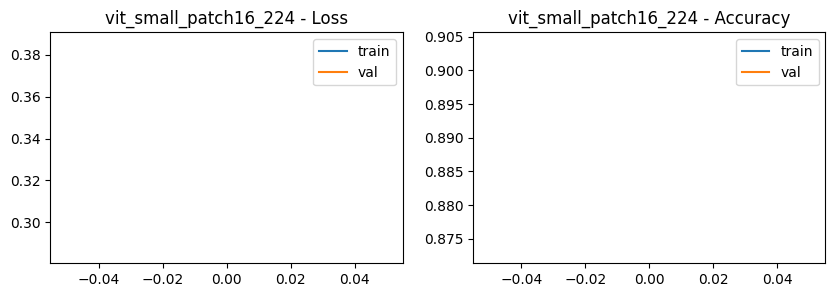

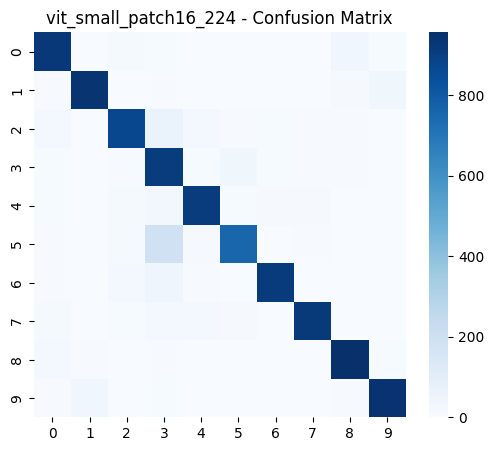


MODEL: swin_tiny_patch4_window7_224
Epoch 1/1 | train_loss=1.0745 | train_acc=0.6091 | val_loss=0.4966 | val_acc=0.8326


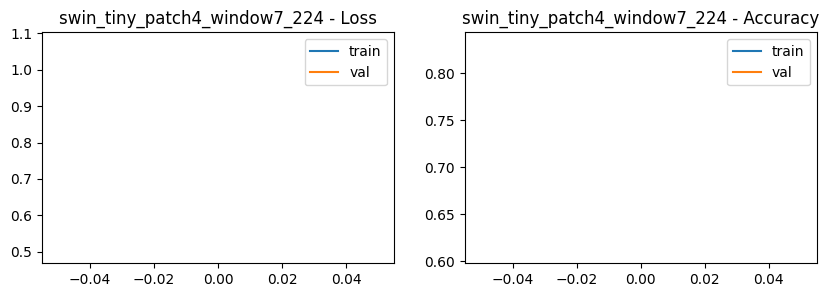

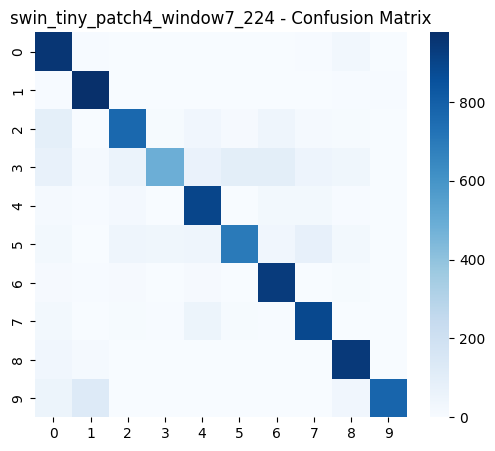

In [ ]:
RESULTS = {}

for m in MODELS:
    print("\n==============================")
    print("MODEL:", m)

    model = build_model(m)
    params = param_info(model)

    history = train(model)
    report, cm = evaluate(model)
    ms, fps = inference_time(model)

    RESULTS[m] = {
        "params": params,
        "report": report,
        "inference_ms": ms,
        "fps": fps
    }

    # Curves
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(history["loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title(m + " - Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["acc"], label="train")
    plt.plot(history["val_acc"], label="val")
    plt.title(m + " - Accuracy"); plt.legend()
    plt.show()

    # Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(m + " - Confusion Matrix")
    plt.show()


In [ ]:
rows = []

for m, r in RESULTS.items():
    rows.append({
        "model": m,
        "params_total": r["params"]["total"],
        "params_trainable": r["params"]["trainable"],
        "size_mb": r["params"]["size_mb"],
        "val_acc": r["report"]["accuracy"],
        "inference_ms": r["inference_ms"],
        "fps": r["fps"]
    })

df = pd.DataFrame(rows)
df


,model,params_total,params_trainable,size_mb,val_acc,inference_ms,fps
0,vit_small_patch16_224,21669514,21669514,82.66,0.9041,100.241295,9.975929
1,swin_tiny_patch4_window7_224,27527044,27527044,105.01,0.8326,137.374855,7.279353
